imports

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import pandas.io.sql as pandasql
import datetime
from psycopg2 import connect
from matplotlib.dates import DateFormatter
from cycler import cycler

## Exploring time of day variation
Having determined the five different categories of non-holiday traffic days, I wanted to explore how median travel times vary over the day at the 20 different collection sites for the 5 different day types. 

In [2]:
#Setting up postgresql connection
con = connect(database='rad',host='localhost',user='python',password='py')

In [3]:
#Travel time data
mediantt_bytod = pandasql.read_sql("WITH exc AS(SELECT holidate, holiday, to_char(holidate, 'Day') as dow"
    "  FROM public.holidays "
    "UNION "
    "SELECT holidate - 3, 'Friday Before '||holiday, to_char(holidate -3, 'Day') "
    "FROM public.holidays "
    "WHERE to_char(holidate, 'ID') = '1') "
    ", medians AS("
    "SELECT daytype, startpointname||'-'||endpointname as segment,timeofday"
    ", percentile_cont(  0.5) WITHIN GROUP (ORDER BY medianmeasuredtime ) as medianmeasuredtime "
    "FROM to_data "
    "INNER JOIN daytypes USING (isodow) "
    "WHERE rx_time NOT IN (SELECT holidate from exc) "
    "GROUP BY daytype, startpointname, endpointname,timeofday) "
    "SELECT daytype, segment, timeofday, medianmeasuredtime, inbound "
    ", medianmeasuredtime/(MIN(medianmeasuredtime) OVER (PARTITION BY daytype,segment)) as medianttprop "
     "FROM medians "
     "INNER JOIN (SELECT inbound, startpointname||'-'||endpointname as segment FROM to_stations_dir) dirs using(segment) "
     "ORDER BY daytype, inbound, segment, timeofday",con)
mediantt_bytod.timeofday = pd.to_datetime(mediantt_bytod.timeofday, format="%H:%M:%S")
daytypes = mediantt_bytod.daytype.unique()
seg_names = mediantt_bytod.segment.unique()

In [ ]:
# To test multiple plotting below for the cell below
# ax_r = -1
# ax_c = 0

# for daytype in daytypes:
#     ax_r = ax_r + 1
#     for i in range(0,2): #Inbound
#         ax_c = i
#         seg_names = segment_dir[segment_dir["inbound"]==i].segment
#         for seg_name in seg_names.sort_values():
#              print(daytype, i, ax_r, ax_c, seg_name)

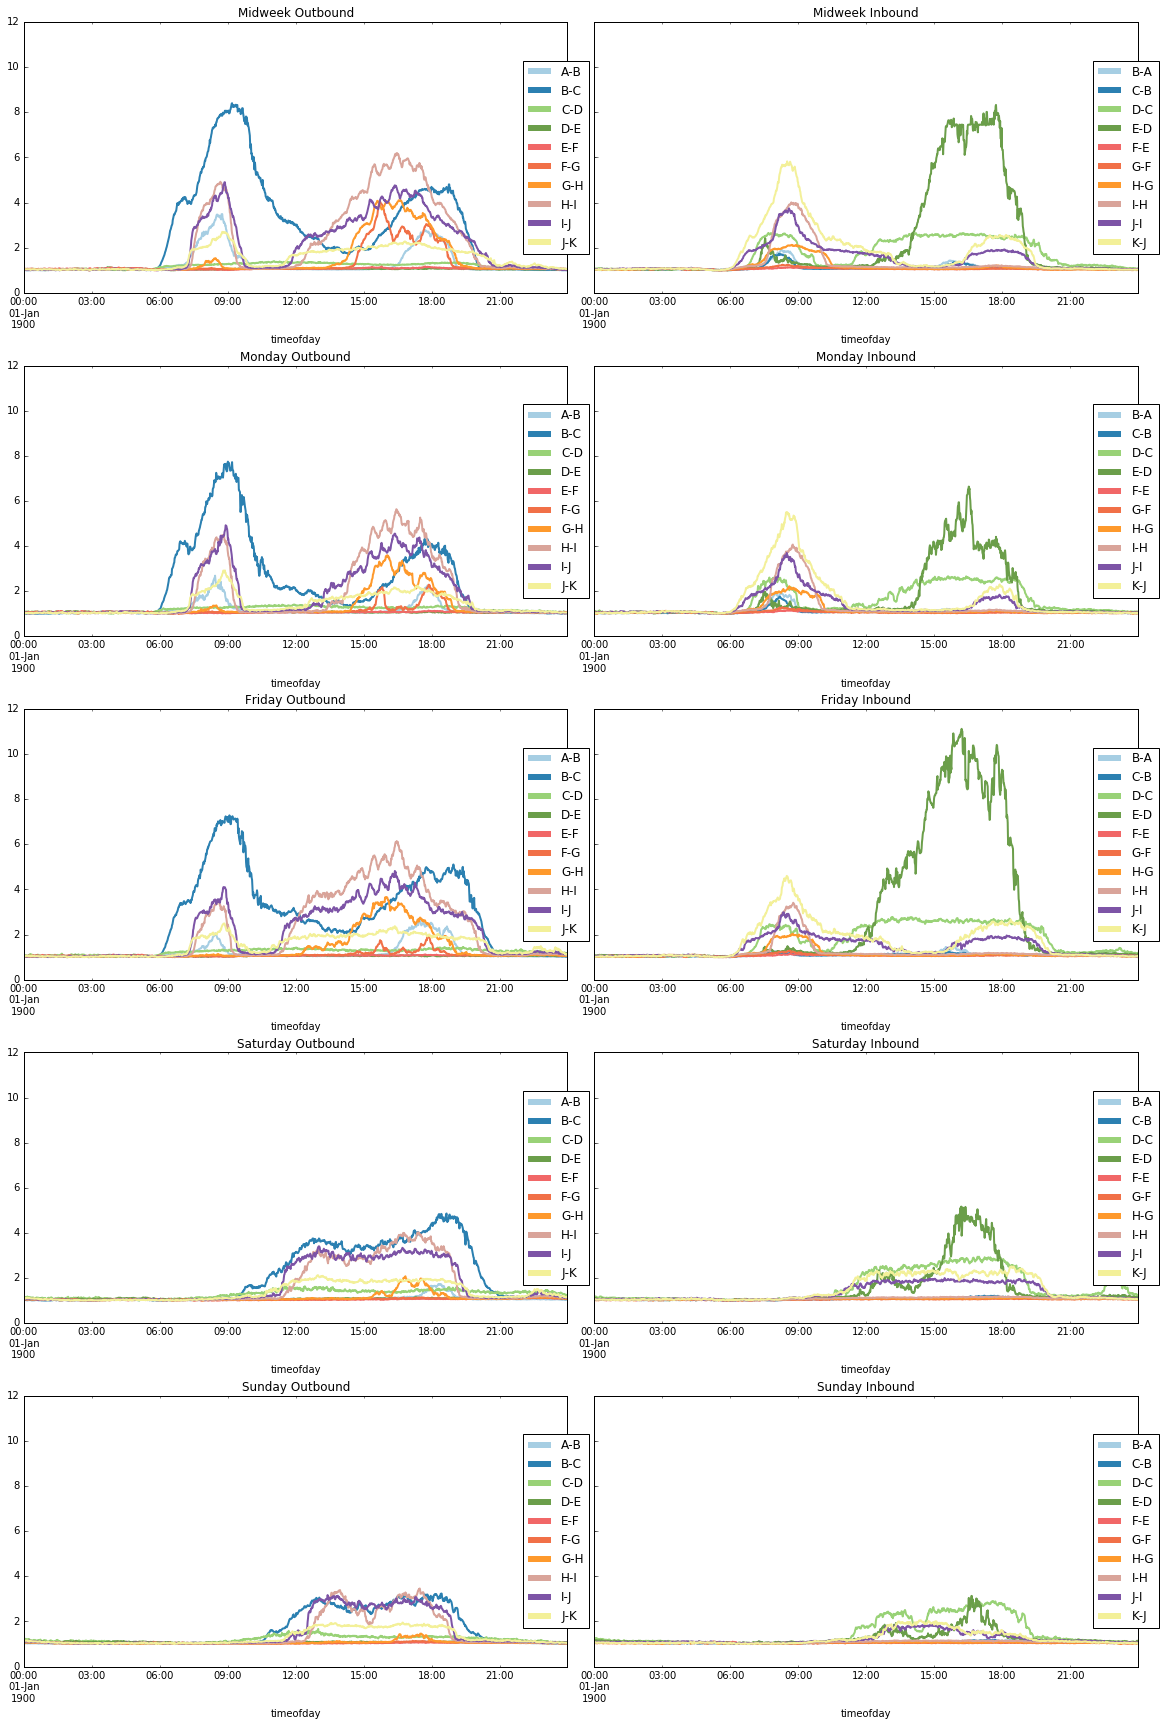

In [13]:
#Plotting the travel time ratio by daytype, direction, segment, and time of day
fig, ax = plt.subplots(5,2, figsize=(16,24), sharey=True)
#Setting colors
NUM_COLORS = 10
cm = plt.get_cmap('Paired')
color_cycler = cycler('color',[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

dow_sorter= ['Midweek','Monday', 'Friday', 'Saturday', 'Sunday']

ax_r = -1
ax_c = 0

for daytype in dow_sorter:
    ax_r = ax_r + 1
    for i in range(0,2): #Inbound
        ax_c = i
        seg_names = segment_dir[segment_dir["inbound"]==i].segment
        ax[ax_r,ax_c].set_prop_cycle(color_cycler)
        for seg_name in seg_names.sort_values():
            mediantt_bytod[(mediantt_bytod["daytype"]==daytype) & (mediantt_bytod["segment"]==seg_name) 
                           & (mediantt_bytod["inbound"]==i)].plot(x='timeofday',y='medianttprop',
                             linewidth=2, ax=ax[ax_r,ax_c],label=seg_name)
        leg = ax[ax_r,ax_c].legend(loc='center right',bbox_to_anchor=(1.05,0.5))
        for legobj in leg.legendHandles:
            legobj.set_linewidth(6.0)
        ax[ax_r,ax_c].set_title((daytype + ' ' + ('Inbound' if i == 1 else 'Outbound' )))
#         ax[ax_r,ax_c].set_xlabel(visible=False)
#         if ax_r in (0,4) :
#         ax[ax_r,ax_c].xaxis.set_major_formatter(DateFormatter('%H:%M'))
#         else:
#             ax[ax_r,ax_c].xaxis.set_visible(False)
#         if ax_c == 0:
#             ax[ax_r,ax_c].yaxis.set_visible(True)
#         else:
#             ax[ax_r,ax_c].yaxis.set_visible(False)

# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
# plt.setp([a.get_xticklabels() for a in ax[4, :]], visible=True)
# plt.setp([a.get_yticklabels() for a in ax[:, 0]], visible=True)
# fig.text(0.06, 0.5, 'Median Travel Time/Free Flow Travel Time', ha='center', va='center', rotation='vertical')
# fig.text(0.5, 0.04, 'Time of Day', ha='center', va='center')
plt.tight_layout()

plt.show()

In [10]:
#To Check the sample count for each segment by day type
#Loading data from database
veh_samples = pandasql.read_sql(" WITH exc AS(SELECT holidate, holiday, to_char(holidate, 'Day') as dow "
     "  FROM public.holidays  "
     "UNION  "
     "SELECT holidate - 3, 'Friday Before '||holiday, to_char(holidate -3, 'Day') " 
     "FROM public.holidays  "
    " WHERE to_char(holidate, 'ID') = '1')  "
     "SELECT daytype, startpointname||'-'||endpointname as segment, inbound, samplecount, COUNT(*)  "
     "FROM to_data " 
     "INNER JOIN daytypes USING (isodow)  "
     "INNER JOIN to_stations_dir using(startpointname,endpointname)  "
     "WHERE rx_time NOT IN (SELECT holidate from exc)  "
     "GROUP BY daytype, startpointname, endpointname , inbound, samplecount "
     "ORDER BY daytype, inbound, segment, samplecount ", con)

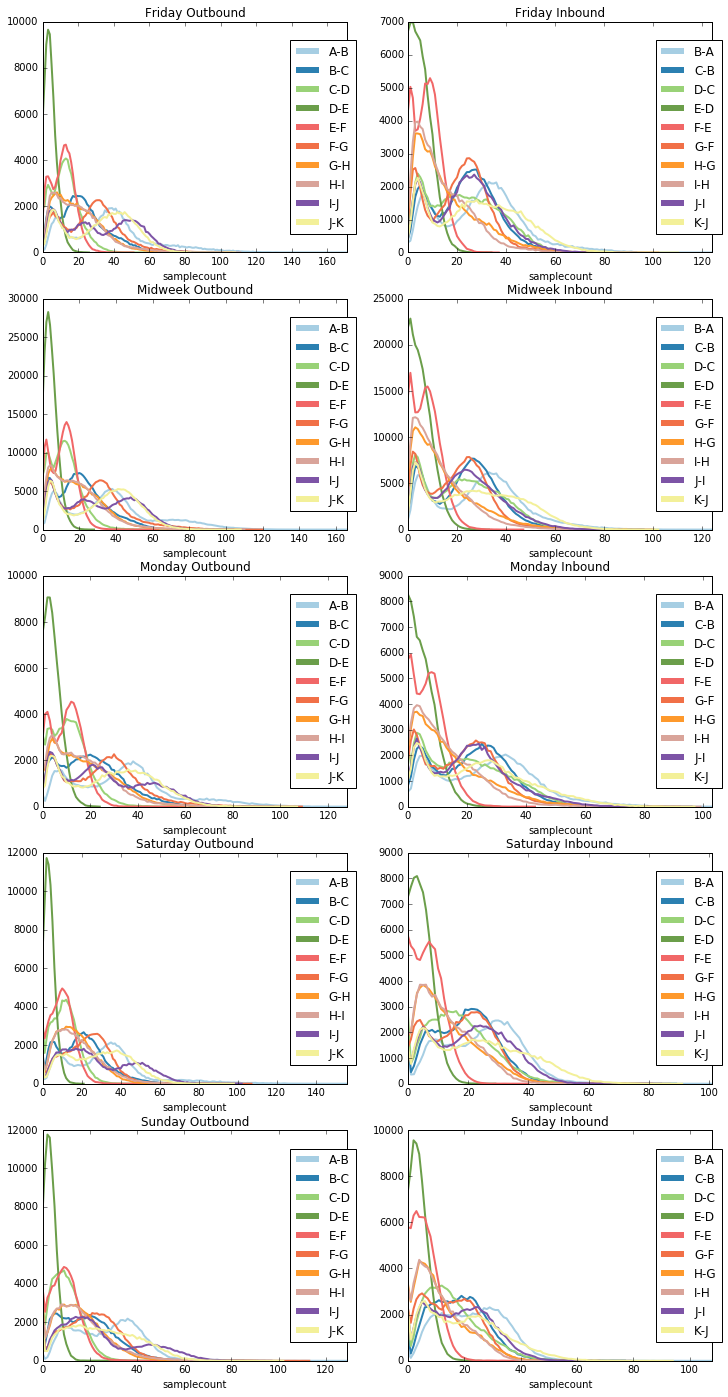

In [19]:
#Plotting sample count
fig, ax = plt.subplots(5,2, figsize=(12,24))
#Setting colors
NUM_COLORS = 10
cm = plt.get_cmap('Paired')
color_cycler = cycler('color',[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

ax_r = -1
ax_c = 0

veh_samples.sort?

for daytype in daytypes:
    ax_r = ax_r + 1
    for i in range(0,2): #Inbound
        ax_c = i
        seg_names = segment_dir[segment_dir["inbound"]==i].segment
        ax[ax_r,ax_c].set_prop_cycle(color_cycler)
        for seg_name in seg_names.sort_values():
            veh_samples[(veh_samples["daytype"]==daytype) & (veh_samples["segment"]==seg_name) 
                           & (veh_samples["inbound"]==i)].plot(x='samplecount',y='count',
                             linewidth=2, ax=ax[ax_r,ax_c],label=seg_name)
        leg = ax[ax_r,ax_c].legend(loc='center right',bbox_to_anchor=(1.05,0.5))
        for legobj in leg.legendHandles:
            legobj.set_linewidth(6.0)
        ax[ax_r,ax_c].set_title((daytype + ' ' + ('Inbound' if i == 1 else 'Outbound' )))

plt.show()